In [1]:
from matplotlib import pyplot as plt
import numpy as np

from fedhex import MADEManager, RootLoader
from fedhex import io as fxio
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

Welcome to JupyROOT 6.30/02


2024-01-18 00:03:51.650435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
rdir = "./root/100x100box_200events/"
tree_name = "Events"
data_vars = ["phi", "omega"]
cond_vars = ["labelphi", "labelomega"]
cutstr = "CBL_Region == 1 and Photon_pt[CBL_RecoPhi_photonindex] > 220"
defs = {
    "phi": "CBL_RecoPhi_mass", 
    "labelphi": "GenPhi_mass[0]",
    "omega": "TwoProng_massPi0[CBL_RecoPhi_twoprongindex]",
    "labelomega": "GenOmega_mass[0]"
}
arr_np = fxio.load_root(root_dir=rdir,
                    tree_name=tree_name,
                    data_vars=data_vars,
                    cond_vars=cond_vars,
                    defs=defs,
                    cutstr=cutstr,
                    event_thresh=0)

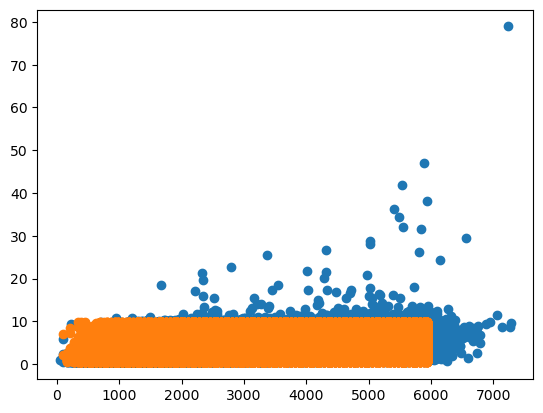

In [3]:
plt.scatter(arr_np[0][:,0], arr_np[0][:,1])
plt.scatter(arr_np[1][:,0], arr_np[1][:,1])

In [4]:
root_path = "./root/100x100box_200events/"
rl = RootLoader(path=root_path)

tree_name = "Events;1"
data_vars = ["phi", "omega"]
cond_vars = ["labelphi", "labelomega"]
cutstr = "CBL_Region == 1 and Photon_pt[CBL_RecoPhi_photonindex] > 220"
defs = {
    "phi": "CBL_RecoPhi_mass", 
    "labelphi": "GenPhi_mass[0]",
    "omega": "TwoProng_massPi0[CBL_RecoPhi_twoprongindex]",
    "labelomega": "GenOmega_mass[0]"
}

thresh = 150
samples, labels = rl.load(
    tree_name=tree_name,
    data_vars=data_vars,
    cond_vars=cond_vars,
    cutstr=cutstr,
    defs=defs,
    event_thresh=thresh)

data, cond = rl.preproc()

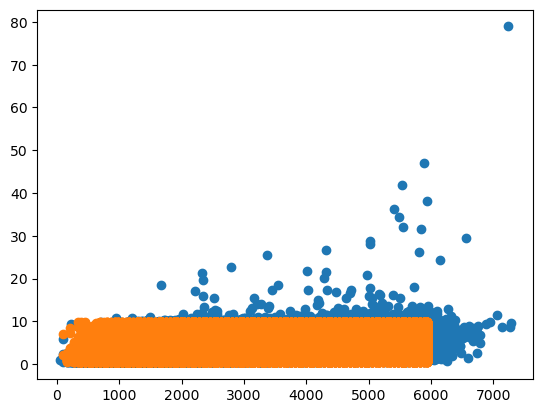

In [5]:
plt.scatter(samples[:,0], samples[:,1])
plt.scatter(labels[:,0], labels[:,1])

In [6]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    lr_tuple=lr_tuple)

mm.compile_model()

starting_epoch = 0
end_epoch = 20
batch_size = 1024
flow_path = "./model/save_test_2024-01-18/"
loss_path = flow_path + "loss.npy"


callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [7]:
trn_samples = data
trn_labels = cond
mm.train_model(data=trn_samples, cond=trn_labels, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

00:04:26.66 <I> [Training begins]
epoch begin: 2024-01-18 00:04:52.799660 | time elapsed: 0:00:26.031906
Epoch 10/20
107/107 [==============================] - 2s 18ms/sample - loss: -0.1279
epoch begin: 2024-01-18 00:05:11.352123 | time elapsed: 0:00:44.584369
Epoch 20/20
107/107 [==============================] - 2s 18ms/sample - loss: -0.3950
INFO:tensorflow:Assets written to: ./model/save_test_2024-01-18/assets


INFO:tensorflow:Assets written to: ./model/save_test_2024-01-18/assets
/home/asatk/miniconda3/envs/rootflows/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/home/asatk/miniconda3/envs/rootflows/lib/python3.11/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


00:05:24.89 <I> [Training ends]
0:00:58.23 <I> [Time elapsed]


In [8]:
ngen = 500
gen_labels_unique = [2464., 5.125]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = rl.norm(gen_labels, is_cond=True)

gen_data = mm.eval_model(gen_cond)

gen_samples = rl.denorm(gen_data, is_cond=False)

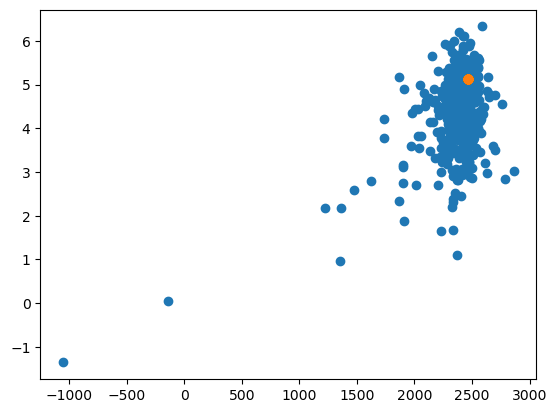

In [9]:
plt.scatter(gen_samples[:,0], gen_samples[:,1])
plt.scatter(gen_labels[:,0], gen_labels[:,1])

In [10]:
save_path = "temp.root"
save_tree = "tree"
fxio.save_root(
    path=save_path,
    tree_name=save_tree,
    gen_samples=gen_samples,
    gen_labels=gen_labels,
    trn_samples=trn_samples,
    trn_labels=trn_labels)

True